### Importing Pandas, Numpy, Matplotlib and our ANN Classes

In [67]:
import pandas as pd
import numpy as np
from model import Model
from layer import Linear, ActivationFunc
from loss import Loss
from network import SequentialNetwork
from optimizer import Optimizer, adamOptimizer
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
import matplotlib.patches as mpatches
from model import Model
from sklearn.metrics import confusion_matrix

<br>

### Loading Testing Data

In [68]:
testingData = np.load('trainingData.npy')
testingData = testingData.T
print('First 5 rows of testing data: ')
print('\n')
print(testingData[:5,:])

testing_intputs = testingData[:,0:2]
testing_truth = testingData[:,2]
#obtaining 40 red giants for training because our orginial set did not include any red giants

numGiants = 0
i = 0
trainingGiants = np.empty((40,3))
while numGiants < 40:
    if testingData[i,2] == 3.0:
        trainingGiants[numGiants,:] = testingData[i,:]
        numGiants +=1
    i += 1


First 5 rows of testing data: 


[[1.17345376e+00 9.40670000e+03 2.00000000e+00]
 [1.23644014e+00 9.34870000e+03 2.00000000e+00]
 [2.44323031e+00 7.52070000e+03 2.00000000e+00]
 [1.69415001e+00 7.05230000e+03 2.00000000e+00]
 [1.18376330e+00 9.98280000e+03 2.00000000e+00]]


## Top Of Our Dataset 
(The CSV we first Used, but with brown dwarfs dropped)

In [69]:
df = pd.read_csv("6class.csv")
df_minus_bd = df[~((df['Star type'] == 0))]
df_minus_bd.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
10,3600,0.0029,0.5100,10.690,1,Red,M
11,3129,0.0122,0.3761,11.790,1,Red,M
12,3134,0.0004,0.1960,13.210,1,Red,M
13,3628,0.0055,0.3930,10.480,1,Red,M
14,2650,0.0006,0.1400,11.782,1,Red,M


<br>

### Preparing Our Dataset For Training 
-Dropping unused rows <br>
-Adding 40 Red Giants <br>
-Normalizing and shuffling data 

In [70]:
inputs = np.array(df_minus_bd.drop(['Star type', 'Luminosity(L/Lo)', 'Star color', 'Radius(R/Ro)', 'Spectral Class'], axis=1))
truth = np.array(df_minus_bd['Star type'])

for i in range(len(truth)):
    if truth[i] <= 3:
        truth[i] = truth[i] - 1

truth = np.concatenate((truth, trainingGiants[:,2]), axis = 0)
truth.shape = (len(truth), 1)

inputs[:,[0,1]] = inputs[:,[1,0]]
inputs = np.vstack((inputs, trainingGiants[:,0:2]))

mean = np.mean(inputs, axis=0)
std = np.std(inputs, axis=0)

std[std == 0] = 1e-8

normalized_inputs = (inputs - mean) / std

inputs = normalized_inputs

shuffle = np.random.permutation(len(inputs))
inputs = inputs[shuffle]
truth = truth[shuffle]


testing_intputs_norm = (testing_intputs - mean)/ std

shuffle = np.random.permutation(len(testing_truth))
testing_intputs_norm_shuffled = testing_intputs_norm[shuffle]
testing_truth_shuffled = testing_truth[shuffle]

val_inputs = testing_intputs_norm_shuffled[:50,:]
val_truth = testing_truth_shuffled[0:50]

<br>

### Setting up the Nueral Net

Note: You can change the hyperparameters if you wish

In [71]:
star_nn = Model()

star_nn.addLayer(Linear(input_size = 2, output_size =32))
star_nn.addLayer(ActivationFunc("relu"))

star_nn.addLayer(Linear(input_size = 32, output_size = 16))
star_nn.addLayer(ActivationFunc("relu"))

star_nn.addLayer(Linear(input_size = 16, output_size = 6))

star_nn.compile(learning_rate = 1e-3) 

<br>

### Initializing Variables and Function for Graphing

In [72]:
label_map = {0 : 'Red Dwarf',1 : 'White Dwarf',2 : 'Main Sequence',3 : 'Red Giant',4 : 'Supergiant',5 : 'Hypergiant'}

size_map = {0: 1,1: 1,  2: 1,   3: 1, 4: 40,   5: 50, }

starColorPallet = {0 : '#d73027',  1: '#e0f3f8',    2: '#fee090', 3 : '#fdae61',4: '#74add1', 5: '#c2a5cf'  }


In [73]:
def graph(pred,title):
    sns.set(rc={'axes.facecolor':'black'})
    sns.scatterplot(x=testing_intputs[:,1],y=testing_intputs[:,0],size=pred,sizes=size_map,hue=pred,palette=starColorPallet,alpha=0.7,legend=False)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Absolute magnitude(Mv)')
    plt.title(title)
    patches = [mpatches.Patch(color=starColorPallet[i], label=label_map[i]) for i in np.flip(label_map.keys())]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2.5, labelcolor = "white")
    plt.xticks([30000, 10000,3000, 1000], ['30000', '10000','3000', '1000'])
    plt.show()

<br>

### Plotting The Graph Generated From the Testing Data and The Untrained Model's Predictions 

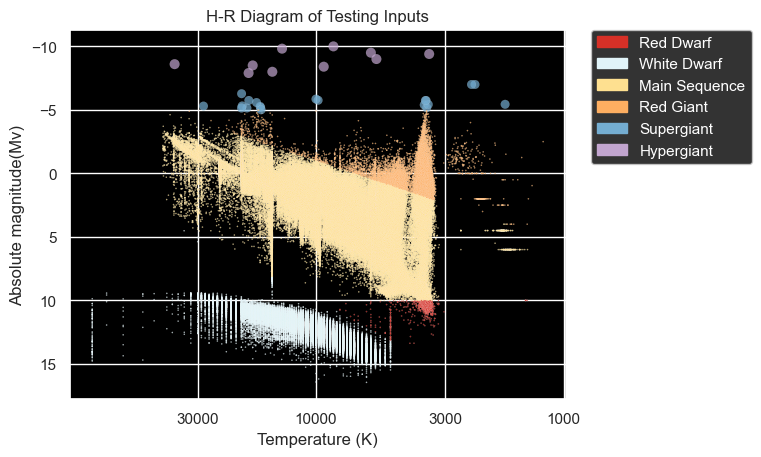

In [74]:
graph(testing_truth,'H-R Diagram of Testing Inputs')

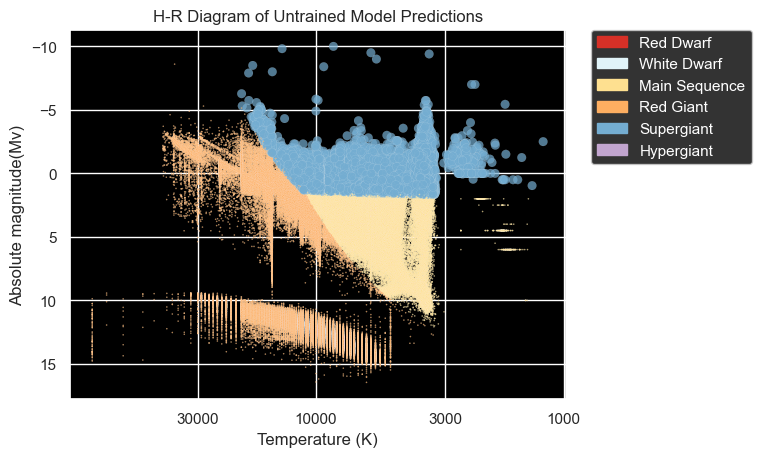

In [75]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 
graph(pred_arr, 'H-R Diagram of Untrained Model Predictions')

### Training the  Network

In [76]:
star_nn.train(inputs = inputs,truth= truth, val_inputs = val_inputs, val_truth = val_truth, epochs = 1000, batch_size = 16)

Starting training:
Epoch: 1, Loss: 29.4893
Epoch: 2, Loss: 26.5969
Epoch: 3, Loss: 24.1385
Epoch: 4, Loss: 21.7731
Epoch: 5, Loss: 19.5654
Epoch: 6, Loss: 17.5280
Epoch: 7, Loss: 15.7532
Epoch: 8, Loss: 13.9971
Epoch: 9, Loss: 12.1601
Epoch: 10, Loss: 10.4736
Epoch: 11, Loss: 8.9603
Epoch: 12, Loss: 7.6323
Epoch: 13, Loss: 6.4738
Epoch: 14, Loss: 5.4522
Epoch: 15, Loss: 4.5610
Epoch: 16, Loss: 3.7609
Epoch: 17, Loss: 2.9164
Epoch: 18, Loss: 2.0579
Epoch: 19, Loss: 1.2683
Epoch: 20, Loss: 0.8912
Epoch: 21, Loss: 0.7958
Epoch: 22, Loss: 0.7300
Epoch: 23, Loss: 0.6915
Epoch: 24, Loss: 0.6590
Epoch: 25, Loss: 0.6355
Epoch: 26, Loss: 0.6132
Epoch: 27, Loss: 0.5916
Epoch: 28, Loss: 0.5722
Epoch: 29, Loss: 0.5578
Epoch: 30, Loss: 0.5407
Epoch: 31, Loss: 0.5283
Epoch: 32, Loss: 0.5136
Epoch: 33, Loss: 0.5003
Epoch: 34, Loss: 0.4901
Epoch: 35, Loss: 0.4816
Epoch: 36, Loss: 0.4697
Epoch: 37, Loss: 0.4593
Epoch: 38, Loss: 0.4507
Epoch: 39, Loss: 0.4420
Epoch: 40, Loss: 0.4347
Epoch: 41, Loss: 0.4

<br>

### The Neural Network's Final Prediction

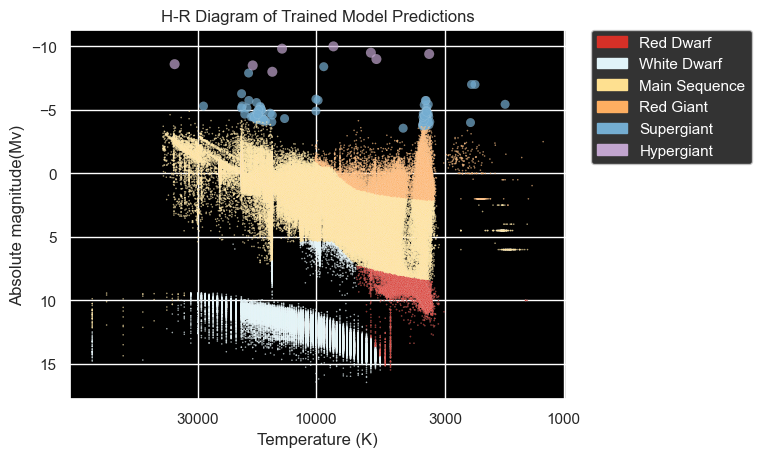

In [77]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 
graph(pred_arr,'H-R Diagram of Trained Model Predictions')

<br>

### Loss and Loss Validation Charts

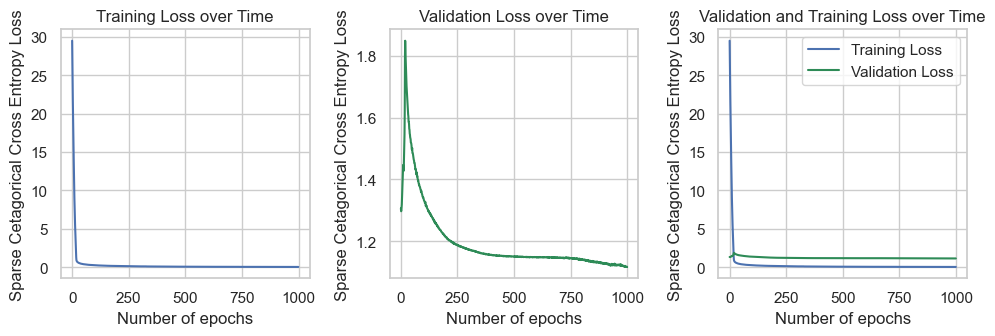

In [78]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.set_size_inches(10, 5)

ax1.set_box_aspect(1)
ax1.plot(np.arange(star_nn.num_epochs), star_nn.metrics['train_loss'])
ax1.set_title('Training Loss over Time')
ax1.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax1.set_xlabel('Number of epochs')

ax2.set_box_aspect(1)
ax2.plot(np.arange(star_nn.num_epochs), star_nn.metrics['val_pred_loss'], color = 'seagreen')
ax2.set_title('Validation Loss over Time')
ax2.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax2.set_xlabel('Number of epochs')


ax3.set_box_aspect(1)
ax3.plot(np.arange(star_nn.num_epochs), star_nn.metrics['train_loss'],label ="Training Loss")
ax3.plot(np.arange(star_nn.num_epochs), star_nn.metrics['val_pred_loss'],label = "Validation Loss", color = 'seagreen')
ax3.set_title('Validation and Training Loss over Time')
ax3.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax3.set_xlabel('Number of epochs')
ax3.legend()


plt.tight_layout() 
plt.show()

<br>

### Training and Validation Accuracy Charts and Category Accuracy

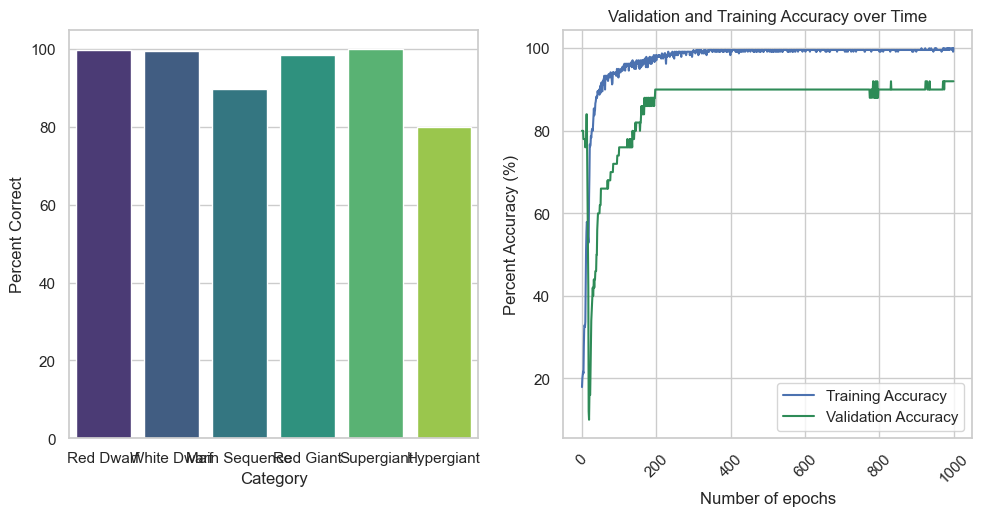

In [79]:
sns.set_style("whitegrid")

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))
fig.set_size_inches(10, 5)

pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 

accuracy_per_star = []

for num in sorted(label_map.keys()):
    indx = np.where(testing_truth == num)[0]
    if len(indx) > 0:
        num_correct = np.sum(testing_truth[indx] == pred_arr[indx])
        total_in_category = len(indx)
        
        percent_correct = (num_correct / total_in_category) * 100
        accuracy_per_star.append({
            'Category': label_map[num],
            'Percent Correct': percent_correct
        })
    else:
        accuracy_per_star.append({
            'Category': label_map[num],
            'Percent Correct': 0
        })

accuracy_per_starType_df = pd.DataFrame(accuracy_per_star)
sns.barplot(x='Category', y='Percent Correct', data=accuracy_per_starType_df, palette='viridis', hue='Category', legend=False, ax=ax1)
ax1.set_box_aspect(1)

plt.xlabel('Star Category')
plt.ylabel('Percent Correct (%)')
plt.title('Accuracy by Star Category')
plt.xticks(rotation=15) 


ax3.set_box_aspect(1)
ax3.plot(np.arange(star_nn.num_epochs), [i*100 for i in star_nn.metrics['train_accuracy']],label ="Training Accuracy")
ax3.plot(np.arange(star_nn.num_epochs), [i*100 for i in star_nn.metrics['val_pred_accuracy']],label = "Validation Accuracy", color = 'seagreen')
ax3.set_title('Validation and Training Accuracy over Time')
ax3.set_ylabel('Percent Accuracy (%)')
ax3.set_xlabel('Number of epochs')
ax3.legend()

plt.tight_layout() 
plt.show()

<br>

### Confusion and Prediction Pobablilities

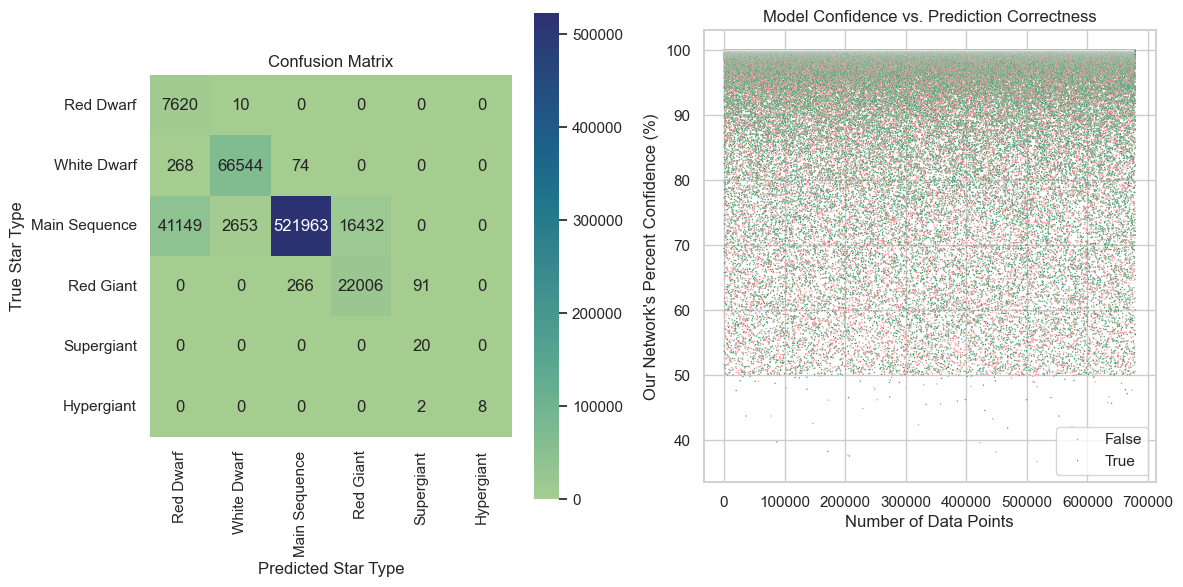

In [80]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 

cm = confusion_matrix(testing_truth, pred_arr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_box_aspect(1)
sns.heatmap(cm,annot=True, fmt='d',cmap='crest',       
            xticklabels=['Red Dwarf', 'White Dwarf', 'Main Sequence','Red Giant', 'Supergiant', 'Hypergiant'], 
            yticklabels=['Red Dwarf', 'White Dwarf', 'Main Sequence','Red Giant', 'Supergiant', 'Hypergiant'], ax =ax1)
ax1.set_xlabel('Predicted Star Type')
ax1.set_ylabel('True Star Type')
ax1.set_title('Confusion Matrix')

ax2.set_box_aspect(1)

pred = star_nn.predict(testing_intputs_norm_shuffled)
pred_arr = np.argmax(pred, axis=1) 

confidence = np.max(pred, axis=1)
is_right = (pred_arr == testing_truth_shuffled)
sns.scatterplot( x=np.arange(len(pred_arr)),y=confidence*100,hue=is_right,palette=['lightcoral', 'seagreen'],s=1, ax = ax2)
plt.xlabel('Number of Data Points')
plt.ylabel('Our Network\'s Percent Confidence (%)' )
plt.title('Model Confidence vs. Prediction Correctness')
plt.legend(loc='lower right')
plt.tight_layout() 
plt.show()



<br>

### H-R Diagram Training Progression Over Time

Starting training:
Epoch: 1, Loss: 12.7793
Training completed!


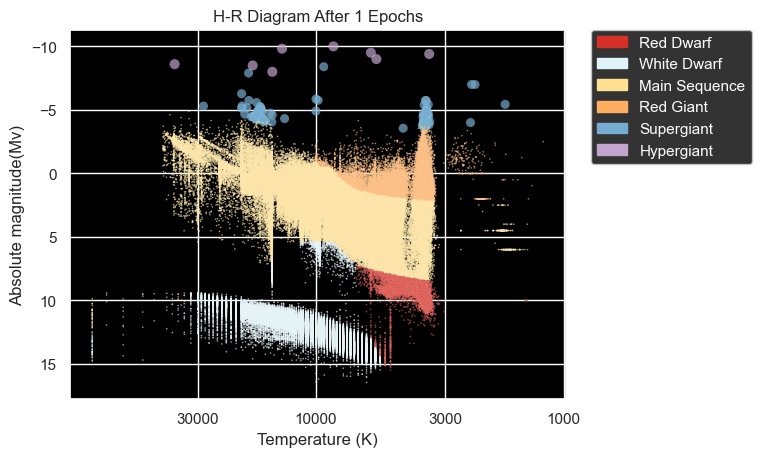

Starting training:
Epoch: 2, Loss: 11.1270
Epoch: 3, Loss: 9.7435
Epoch: 4, Loss: 8.5106
Epoch: 5, Loss: 7.4026
Epoch: 6, Loss: 6.4122
Training completed!


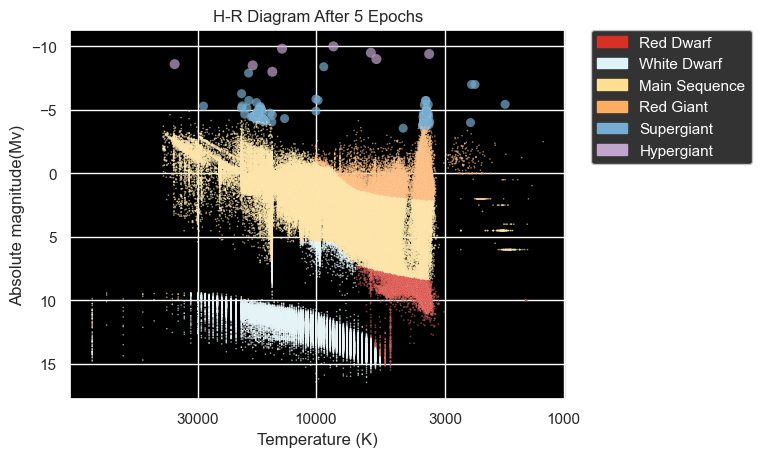

Starting training:
Epoch: 7, Loss: 5.5407
Epoch: 8, Loss: 4.8363
Epoch: 9, Loss: 4.2483
Epoch: 10, Loss: 3.7729
Epoch: 11, Loss: 3.4485
Epoch: 12, Loss: 3.1822
Epoch: 13, Loss: 2.9275
Epoch: 14, Loss: 2.6870
Epoch: 15, Loss: 2.4775
Epoch: 16, Loss: 2.2743
Training completed!


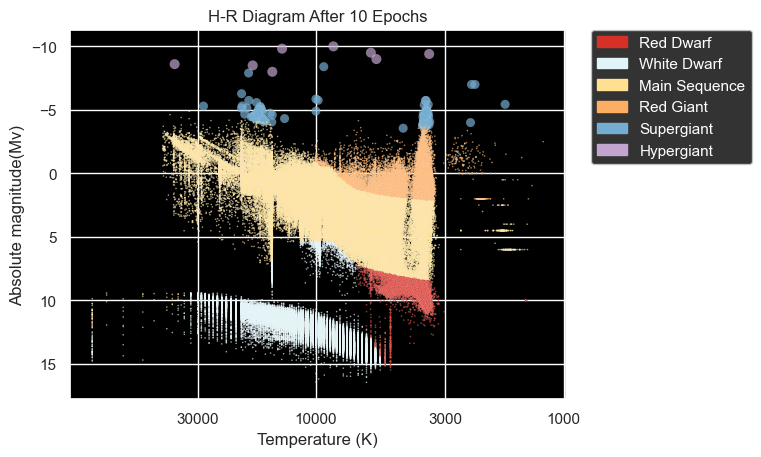

Starting training:
Epoch: 17, Loss: 2.0766
Epoch: 18, Loss: 1.9067
Epoch: 19, Loss: 1.7473
Epoch: 20, Loss: 1.5945
Epoch: 21, Loss: 1.4853
Epoch: 22, Loss: 1.3686
Epoch: 23, Loss: 1.2702
Epoch: 24, Loss: 1.1871
Epoch: 25, Loss: 1.0907
Epoch: 26, Loss: 1.0025
Epoch: 27, Loss: 0.8937
Epoch: 28, Loss: 0.7280
Epoch: 29, Loss: 0.6306
Epoch: 30, Loss: 0.5980
Epoch: 31, Loss: 0.5745
Epoch: 32, Loss: 0.5528
Epoch: 33, Loss: 0.5367
Epoch: 34, Loss: 0.5202
Epoch: 35, Loss: 0.5074
Epoch: 36, Loss: 0.4937
Epoch: 37, Loss: 0.4848
Epoch: 38, Loss: 0.4651
Epoch: 39, Loss: 0.4563
Epoch: 40, Loss: 0.4470
Epoch: 41, Loss: 0.4396
Training completed!


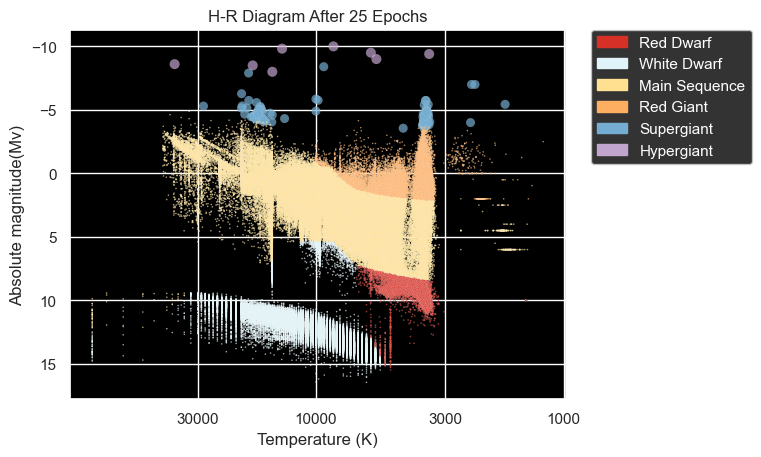

Starting training:
Epoch: 42, Loss: 0.4263
Epoch: 43, Loss: 0.4162
Epoch: 44, Loss: 0.4088
Epoch: 45, Loss: 0.3988
Epoch: 46, Loss: 0.3898
Epoch: 47, Loss: 0.3828
Epoch: 48, Loss: 0.3748
Epoch: 49, Loss: 0.3677
Epoch: 50, Loss: 0.3606
Epoch: 51, Loss: 0.3598
Epoch: 52, Loss: 0.3482
Epoch: 53, Loss: 0.3402
Epoch: 54, Loss: 0.3353
Epoch: 55, Loss: 0.3276
Epoch: 56, Loss: 0.3229
Epoch: 57, Loss: 0.3143
Epoch: 58, Loss: 0.3108
Epoch: 59, Loss: 0.3045
Epoch: 60, Loss: 0.3021
Epoch: 61, Loss: 0.2937
Epoch: 62, Loss: 0.2889
Epoch: 63, Loss: 0.2866
Epoch: 64, Loss: 0.2788
Epoch: 65, Loss: 0.2749
Epoch: 66, Loss: 0.2691
Epoch: 67, Loss: 0.2667
Epoch: 68, Loss: 0.2613
Epoch: 69, Loss: 0.2574
Epoch: 70, Loss: 0.2552
Epoch: 71, Loss: 0.2490
Epoch: 72, Loss: 0.2493
Epoch: 73, Loss: 0.2425
Epoch: 74, Loss: 0.2402
Epoch: 75, Loss: 0.2369
Epoch: 76, Loss: 0.2361
Epoch: 77, Loss: 0.2319
Epoch: 78, Loss: 0.2304
Epoch: 79, Loss: 0.2256
Epoch: 80, Loss: 0.2261
Epoch: 81, Loss: 0.2217
Epoch: 82, Loss: 0.21

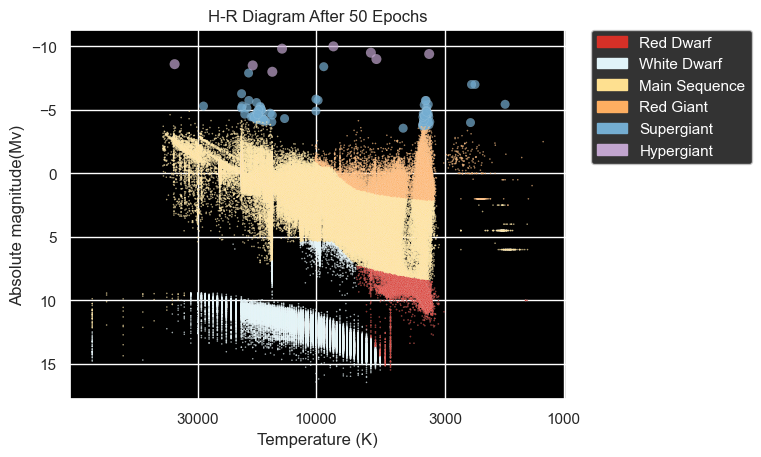

Starting training:
Epoch: 92, Loss: 0.1885
Epoch: 93, Loss: 0.1873
Epoch: 94, Loss: 0.1857
Epoch: 95, Loss: 0.1819
Epoch: 96, Loss: 0.1808
Epoch: 97, Loss: 0.1761
Epoch: 98, Loss: 0.1759
Epoch: 99, Loss: 0.1758
Epoch: 100, Loss: 0.1815
Epoch: 101, Loss: 0.1758
Epoch: 102, Loss: 0.1679
Epoch: 103, Loss: 0.1689
Epoch: 104, Loss: 0.1680
Epoch: 105, Loss: 0.1652
Epoch: 106, Loss: 0.1629
Epoch: 107, Loss: 0.1637
Epoch: 108, Loss: 0.1608
Epoch: 109, Loss: 0.1602
Epoch: 110, Loss: 0.1594
Epoch: 111, Loss: 0.1588
Epoch: 112, Loss: 0.1629
Epoch: 113, Loss: 0.1574
Epoch: 114, Loss: 0.1536
Epoch: 115, Loss: 0.1541
Epoch: 116, Loss: 0.1537
Epoch: 117, Loss: 0.1517
Epoch: 118, Loss: 0.1522
Epoch: 119, Loss: 0.1497
Epoch: 120, Loss: 0.1485
Epoch: 121, Loss: 0.1474
Epoch: 122, Loss: 0.1485
Epoch: 123, Loss: 0.1458
Epoch: 124, Loss: 0.1455
Epoch: 125, Loss: 0.1445
Epoch: 126, Loss: 0.1441
Epoch: 127, Loss: 0.1439
Epoch: 128, Loss: 0.1421
Epoch: 129, Loss: 0.1437
Epoch: 130, Loss: 0.1453
Epoch: 131, Lo

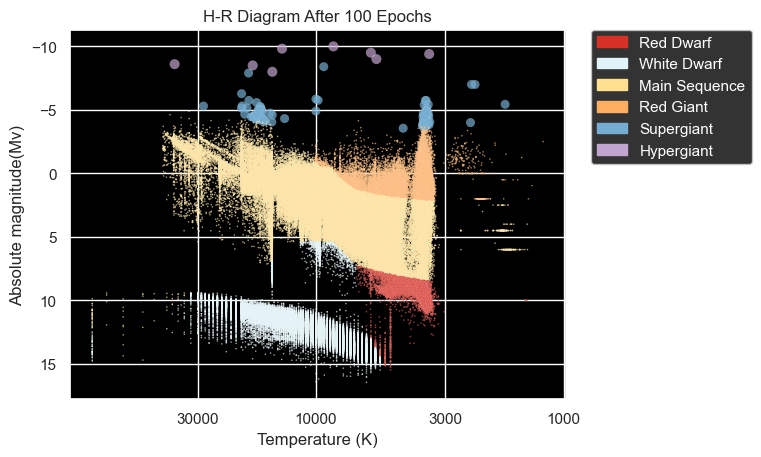

Starting training:
Epoch: 192, Loss: 0.1013
Epoch: 193, Loss: 0.0998
Epoch: 194, Loss: 0.1033
Epoch: 195, Loss: 0.1070
Epoch: 196, Loss: 0.0982
Epoch: 197, Loss: 0.0991
Epoch: 198, Loss: 0.0973
Epoch: 199, Loss: 0.0967
Epoch: 200, Loss: 0.0973
Epoch: 201, Loss: 0.0952
Epoch: 202, Loss: 0.0974
Epoch: 203, Loss: 0.0945
Epoch: 204, Loss: 0.0953
Epoch: 205, Loss: 0.0935
Epoch: 206, Loss: 0.0931
Epoch: 207, Loss: 0.0944
Epoch: 208, Loss: 0.0960
Epoch: 209, Loss: 0.0924
Epoch: 210, Loss: 0.0935
Epoch: 211, Loss: 0.0937
Epoch: 212, Loss: 0.0924
Epoch: 213, Loss: 0.0940
Epoch: 214, Loss: 0.0934
Epoch: 215, Loss: 0.0911
Epoch: 216, Loss: 0.0882
Epoch: 217, Loss: 0.0896
Epoch: 218, Loss: 0.0914
Epoch: 219, Loss: 0.0877
Epoch: 220, Loss: 0.0897
Epoch: 221, Loss: 0.0875
Epoch: 222, Loss: 0.0901
Epoch: 223, Loss: 0.0878
Epoch: 224, Loss: 0.0893
Epoch: 225, Loss: 0.0869
Epoch: 226, Loss: 0.0880
Epoch: 227, Loss: 0.0907
Epoch: 228, Loss: 0.0869
Epoch: 229, Loss: 0.0848
Epoch: 230, Loss: 0.0849
Epoch:

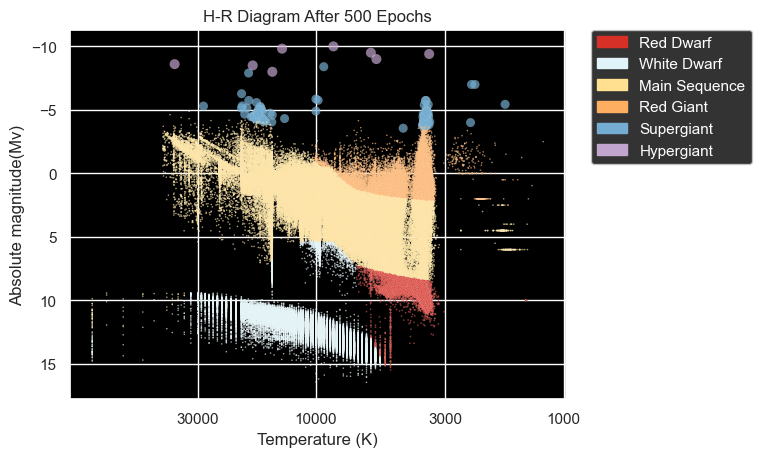

Starting training:
Epoch: 692, Loss: 0.0182
Epoch: 693, Loss: 0.0184
Epoch: 694, Loss: 0.0189
Epoch: 695, Loss: 0.0186
Epoch: 696, Loss: 0.0191
Epoch: 697, Loss: 0.0190
Epoch: 698, Loss: 0.0182
Epoch: 699, Loss: 0.0199
Epoch: 700, Loss: 0.0178
Epoch: 701, Loss: 0.0192
Epoch: 702, Loss: 0.0174
Epoch: 703, Loss: 0.0177
Epoch: 704, Loss: 0.0176
Epoch: 705, Loss: 0.0177
Epoch: 706, Loss: 0.0178
Epoch: 707, Loss: 0.0188
Epoch: 708, Loss: 0.0208
Epoch: 709, Loss: 0.0189
Epoch: 710, Loss: 0.0179
Epoch: 711, Loss: 0.0178
Epoch: 712, Loss: 0.0173
Epoch: 713, Loss: 0.0182
Epoch: 714, Loss: 0.0200
Epoch: 715, Loss: 0.0175
Epoch: 716, Loss: 0.0175
Epoch: 717, Loss: 0.0172
Epoch: 718, Loss: 0.0182
Epoch: 719, Loss: 0.0174
Epoch: 720, Loss: 0.0171
Epoch: 721, Loss: 0.0173
Epoch: 722, Loss: 0.0174
Epoch: 723, Loss: 0.0176
Epoch: 724, Loss: 0.0187
Epoch: 725, Loss: 0.0184
Epoch: 726, Loss: 0.0172
Epoch: 727, Loss: 0.0174
Epoch: 728, Loss: 0.0197
Epoch: 729, Loss: 0.0183
Epoch: 730, Loss: 0.0174
Epoch:

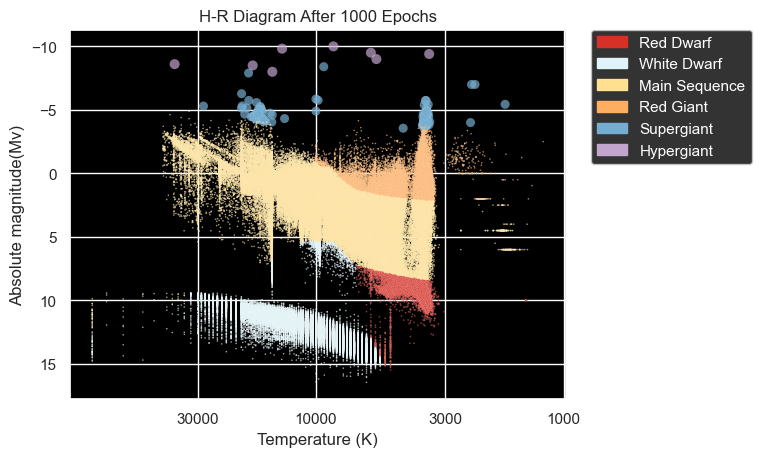

In [81]:
epochs = [1,5, 10, 25, 50, 100, 500, 1000]
star_nn_v2 = Model()

star_nn_v2.addLayer(Linear(input_size = 2, output_size =32))
star_nn_v2.addLayer(ActivationFunc("relu"))

star_nn_v2.addLayer(Linear(input_size = 32, output_size = 16))
star_nn_v2.addLayer(ActivationFunc("relu"))

star_nn_v2.addLayer(Linear(input_size = 16, output_size = 6))

star_nn_v2.compile(learning_rate = 1e-3) 
for e in epochs:
    pred = star_nn.predict(testing_intputs_norm)
    pred_arr = np.argmax(pred, axis=1)
    star_nn_v2.train(inputs = inputs,truth= truth, val_inputs = val_inputs, val_truth = val_truth, epochs = e, batch_size = 16)
    graph(pred_arr, f'H-R Diagram After {e} Epochs')


<br>